In [1]:
!pip install ydata_profiling

In [52]:
import pandas as pd
import seaborn as sns
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [3]:
df = pd.read_csv('/content/HI-Small_Trans.csv').sample(100000, random_state=1997)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Collection**
 This dataset is an AML dataset that has been generated by IBM based on real world transactions that have occurred bewteen individuals, companies and banks. A small fraction of these transactions are spurious in nature (signify signs such as smuggling, illegal gambling, extortion, etc.), and are these labeled as transactions that signify "Money Laundering"

 Using this dataset, we eventually want to predict whether a given transaction is laundering or not.

 For more information, you can look at the link given here:
 https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml?select=HI-Small_Trans.csv


In [5]:
df.head(5)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
948966,2022/09/01 19:17,1688,8006C5000,6010,803E121A0,7249.35,US Dollar,7249.35,US Dollar,Credit Card,0
2720731,2022/09/05 21:59,2053,8042B8200,116715,807F66080,21680242.49,US Dollar,21680242.49,US Dollar,Cheque,0
1900986,2022/09/03 02:12,25075,802217E90,3149,802CB4320,700.48,US Dollar,700.48,US Dollar,Cheque,0
2363625,2022/09/05 03:05,27140,8043EA870,24482,807450FA0,618.35,Euro,618.35,Euro,ACH,0
1477358,2022/09/02 11:17,1916,801BA9490,3881,8057C3590,34.40,Euro,34.40,Euro,Cheque,0


Here are the various columns and their respective definitions:
- **Timestamp**: Year/Month/Day Hour/Minute
- **From Bank**: Numeric code for bank where transaction originates
- **Account** : Hexadecimal code for account where transaction originates
- **To Bank**: Numeric code for bank where transaction ends
- **Account**: Hexadecimal code for account where transaction ends
- **Amount Received** : Monetary amount received in From account (in currency units of the next column)
- **Receiving Currency** : Currency that the recieving account, recieves the money from the originating account.
- **Amount Paid:** : Monetary amount paid (in currency units of the next column)
- **Payment Currency:** Currency that the originating  account, pays the money to the reciving account.
- **Payment Format:** How transaction was conducted, e.g. cheque, ACH, wire, credit cards, etc.
- **Is Laundering:** Whether or not a transacion is reflective of laundering or not

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 948966 to 2289418
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Timestamp           100000 non-null  object 
 1   From Bank           100000 non-null  int64  
 2   Account             100000 non-null  object 
 3   To Bank             100000 non-null  int64  
 4   Account.1           100000 non-null  object 
 5   Amount Received     100000 non-null  float64
 6   Receiving Currency  100000 non-null  object 
 7   Amount Paid         100000 non-null  float64
 8   Payment Currency    100000 non-null  object 
 9   Payment Format      100000 non-null  object 
 10  Is Laundering       100000 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 11.2+ MB


In [7]:
df.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000
mean,45716.246640,66390.138610,3.272222e+06,2.973800e+06,0.001070
std,81693.489404,84422.079028,1.647406e+08,1.626069e+08,0.032694
min,1.000000,1.000000,1.000000e-06,1.000000e-06,0.000000
25%,119.000000,4403.000000,1.827400e+02,1.836950e+02,0.000000
50%,9665.000000,21745.000000,1.420575e+03,1.424675e+03,0.000000
75%,28628.000000,122463.000000,1.223468e+04,1.221132e+04,0.000000
max,356202.000000,356202.000000,2.696998e+10,2.696998e+10,1.000000


We can clearly see that `Amount Received` and `Amount Paid` are the only true integer values. Although `From Bank`, `To Bank` and `Is Laundering` have statistical values attached to them, they are in fact categorical variables (Look at the columns and their respective definitions above).

Let us use the `Profiling` Library in order to understand the counts and percent unique values and ranges of values. ( Note that I only took a sample of 100000 in order to generate this report, because the library was taking up too much RAM, and my notebook kept crashing. Based on my takeaways from the report, I shall apply my findings to the entire scope of the dataset)

In [8]:
profile = ProfileReport(df, title="Profiling Report")

In [9]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Here are some observations from looking at the report above:

- **Timestamp**: Given the information above, there seems to be no missing timestamps for any of the transactions. Keeping the timestamp data and transforming it could be helpful since it could give us critical insights into transaction behaviors that might be indicative of money laundering. We could transform this feature in many ways:
1. Extracting Time Components (year, month, day, hour, minute)
2. Normalizing Continuous Features (year, hour, minutes)
3. Encoding Cyclical Time Featues (Hour, Day of Week, Month)
4. Calculating the time differences
5. Aggregating transactions over specific periods if time to capture the volume and frequency of transacations over time.


- **To bank and From bank:**: Although these features have been reflected as integer values in the report, it is infact a categorical variable. At first look, we might be keen on dropping it, due to it's high cardinality. However, some banks involved in money laundering could could exhibhit specific patterns. For example, some banks might be more frequently associated with spurious transactions that others.


- **Account and Account.1**: This is interesting. If you look at the **Account** value, there seems to be 74,859 unique values. And if you look at **Account.1** values, there seems to be 84,847 unique values. One of these should be the "Originating Account" and the other must be the "Receiving" Account". Hypotheitically, it makes more logical sense that the number of originating account values might be higher than the reciving account values because the receving accounts could be business accounts and the originating accounts coould be individual customer accounts. So lets rename **Account.1** to `Originating_Account` account and **Account** to `Recieving_account`.  Furthemore, this feature also seems to have very high cardinality. Instead of dropping this feature, we can track the frequency of transactions by account, since sudden spikes in transaction frequency could be indicative of laundring or we could also track patterns by account and maybe establish a baseline to check for deviations from the baseline.

- **Recieving Currency and Payment Currency** : Currently the currency is in all forms (US Dollar, Franc, Pesos, etc.). Certain combinations of receiving and payment currencies could be related to data points could be related to data points that exhibhit laundering.  So, we can collect the pairs and then take a frequency of each of the pairs,

- **Payment Format:** Looking at the heatmap in the report, there seems to be some mild positive correlation between the payment format and "is_laundering". There seems to be low cardinality to this feature, so we can just one-hot-encode it.

- **Amount Paid and Amount Recieved**: We shall keep this data the same as it is for now. But when we model, we shall probably fraction out the differnent payment ranges into categories for the sake of better modelling. We can make some interesting features out of this.

- **Is Laundering:** We shall keep this the same, since it's the predictive variable.



In [10]:
df_all = pd.read_csv('/content/HI-Small_Trans.csv')
df_all

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.340000,US Dollar,3697.340000,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.010000,US Dollar,0.010000,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.570000,US Dollar,14675.570000,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.970000,US Dollar,2806.970000,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.970000,US Dollar,36682.970000,US Dollar,Reinvestment,0
...,...,...,...,...,...,...,...,...,...,...,...
5078340,2022/09/10 23:57,54219,8148A6631,256398,8148A8711,0.154978,Bitcoin,0.154978,Bitcoin,Bitcoin,0
5078341,2022/09/10 23:35,15,8148A8671,256398,8148A8711,0.108128,Bitcoin,0.108128,Bitcoin,Bitcoin,0
5078342,2022/09/10 23:52,154365,8148A6771,256398,8148A8711,0.004988,Bitcoin,0.004988,Bitcoin,Bitcoin,0
5078343,2022/09/10 23:46,256398,8148A6311,256398,8148A8711,0.038417,Bitcoin,0.038417,Bitcoin,Bitcoin,0


In [11]:
df_all = df_all.rename(columns = {'Account': 'Recieving_account', 'Account.1':'Originating_Account'})

In [12]:
df_all.isnull().any()

,0
Timestamp,False
From Bank,False
Recieving_account,False
To Bank,False
Originating_Account,False
Amount Received,False
Receiving Currency,False
Amount Paid,False
Payment Currency,False
Payment Format,False


In [13]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Timestamp            object 
 1   From Bank            int64  
 2   Recieving_account    object 
 3   To Bank              int64  
 4   Originating_Account  object 
 5   Amount Received      float64
 6   Receiving Currency   object 
 7   Amount Paid          float64
 8   Payment Currency     object 
 9   Payment Format       object 
 10  Is Laundering        int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


In [14]:
df_all.describe()

,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06,5.078345e+06
mean,4.573057e+04,6.574456e+04,5.988726e+06,4.509273e+06,1.019427e-03
std,8.176562e+04,8.409299e+04,1.037183e+09,8.697728e+08,3.191219e-02
min,1.000000e+00,1.000000e+00,1.000000e-06,1.000000e-06,0.000000e+00
25%,1.190000e+02,4.259000e+03,1.833700e+02,1.844800e+02,0.000000e+00
50%,9.679000e+03,2.156800e+04,1.411010e+03,1.414540e+03,0.000000e+00
75%,2.862800e+04,1.223320e+05,1.234627e+04,1.229784e+04,0.000000e+00
max,3.563030e+05,3.562940e+05,1.046302e+12,1.046302e+12,1.000000e+00


Upon first look, there seems to be no null values in the columns above.

### Time Stamp Column



In [15]:
missing_count_timestamp = df_all['Timestamp'].isnull().sum()
print(f"Number of missing values in 'Timestamp' column: {missing_count_timestamp}")

Number of missing values in 'Timestamp' column: 0


In [16]:
df_all['Timestamp'] = pd.to_datetime(df_all['Timestamp'], format='%Y/%m/%d %H:%M')

# Extracting time components
df_all['Year'] = df_all['Timestamp'].dt.year
df_all['Month'] = df_all['Timestamp'].dt.month
df_all['Day'] = df_all['Timestamp'].dt.day
df_all['Hour'] = df_all['Timestamp'].dt.hour
df_all['Minute'] = df_all['Timestamp'].dt.minute
df_all['DayOfWeek'] = df_all['Timestamp'].dt.dayofweek
df_all['Quarter'] = df_all['Timestamp'].dt.quarter

# TO DO --> normalize the features when feeding them into model
#scaler = StandardScaler()
#df_all[['Year', 'Hour', 'Minute']] = scaler.fit_transform(df_all[['Year', 'Hour', 'Minute']])

# TO DO -->Normalizing cyclical time features when fed into model
'''df_all['Hour_Sin'] = np.sin(2 * np.pi * df_all['Hour'] / 24)
df_all['Hour_Cos'] = np.cos(2 * np.pi * df_all['Hour'] / 24)

df_all['DayOfWeek_sin'] = np.sin(2 * np.pi * df_all['DayOfWeek'] / 7)
df_all['DayOfWeek_cos'] = np.cos(2 * np.pi * df_all['DayOfWeek'] / 7)

df_all['Month_sin'] = np.sin(2 * np.pi * df_all['Month'] / 12)
df_all['Month_cos'] = np.cos(2 * np.pi * df_all['Month'] / 12)'''


# Sort transactions by originating account and timestamp
df_all = df_all.sort_values(by=['Originating_Account', 'Timestamp'])

# Calculate time differences for originating account
df_all['TimeDiff'] = df_all.groupby('Originating_Account')['Timestamp'].diff().dt.total_seconds()
df_all['TimeDiff'].fillna(0, inplace=True)

# TO DO -->Normalizing TimeDIff  features when fed into model
#df_all['TimeDiff'] = scaler.fit_transform(df_all[['TimeDiff']])





df_all.head(5)







,Timestamp,From Bank,Recieving_account,To Bank,Originating_Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month,Day,Hour,Minute,DayOfWeek,Quarter,TimeDiff
88807,2022-09-01 00:06:00,320085,80E0DD780,70,100428660,0.06,US Dollar,0.06,US Dollar,Cash,0,2022,9,1,0,6,3,3,0.0
26047,2022-09-01 00:22:00,31438,8032E38E0,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,0,2022,9,1,0,22,3,3,960.0
499292,2022-09-01 05:38:00,310836,80DFCB240,70,100428660,0.03,US Dollar,0.03,US Dollar,Cash,0,2022,9,1,5,38,3,3,18960.0
767678,2022-09-01 13:37:00,33138,80E2C5A90,70,100428660,0.02,US Dollar,0.02,US Dollar,Cash,0,2022,9,1,13,37,3,3,28740.0
784438,2022-09-01 14:28:00,33407,80E157840,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,0,2022,9,1,14,28,3,3,3060.0


In [17]:
df_all['Year'].nunique()

1

In [18]:
df_all['Month'].nunique()

1

In [19]:
df_all['Quarter'].nunique()

1

In [20]:
#Drop these cloumns, cause they have the same values throughout
df_all = df_all.drop(columns= ['Year', 'Month','Quarter'])

In [21]:
df_all['DayOfWeek'].nunique()


7

In [22]:
df_all['Day'].nunique()

18

In [23]:
df_all.head(5)

,Timestamp,From Bank,Recieving_account,To Bank,Originating_Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Day,Hour,Minute,DayOfWeek,TimeDiff
88807,2022-09-01 00:06:00,320085,80E0DD780,70,100428660,0.06,US Dollar,0.06,US Dollar,Cash,0,1,0,6,3,0.0
26047,2022-09-01 00:22:00,31438,8032E38E0,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,0,1,0,22,3,960.0
499292,2022-09-01 05:38:00,310836,80DFCB240,70,100428660,0.03,US Dollar,0.03,US Dollar,Cash,0,1,5,38,3,18960.0
767678,2022-09-01 13:37:00,33138,80E2C5A90,70,100428660,0.02,US Dollar,0.02,US Dollar,Cash,0,1,13,37,3,28740.0
784438,2022-09-01 14:28:00,33407,80E157840,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,0,1,14,28,3,3060.0


### From Bank/ To Bank



In [ ]:
df_all.columns

Index(['Timestamp', 'From Bank', 'Recieving_account', 'To Bank',
       'Originating_Account', 'Amount Received', 'Receiving Currency',
       'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering',
       'Day', 'Hour', 'Minute', 'DayOfWeek', 'TimeDiff'],
      dtype='object')

In [24]:
features = df_all[[
       'Amount Received', 'Amount Paid',
       'Day', 'Hour', 'Minute', 'DayOfWeek', 'TimeDiff']]

kmeans = KMeans(n_clusters=3)
df_all['From Bank Cluster'] = kmeans.fit_predict(features)
df_all.head(5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Timestamp,From Bank,Recieving_account,To Bank,Originating_Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Day,Hour,Minute,DayOfWeek,TimeDiff,From Bank Cluster
88807,2022-09-01 00:06:00,320085,80E0DD780,70,100428660,0.06,US Dollar,0.06,US Dollar,Cash,0,1,0,6,3,0.0,0
26047,2022-09-01 00:22:00,31438,8032E38E0,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,0,1,0,22,3,960.0,0
499292,2022-09-01 05:38:00,310836,80DFCB240,70,100428660,0.03,US Dollar,0.03,US Dollar,Cash,0,1,5,38,3,18960.0,0
767678,2022-09-01 13:37:00,33138,80E2C5A90,70,100428660,0.02,US Dollar,0.02,US Dollar,Cash,0,1,13,37,3,28740.0,0
784438,2022-09-01 14:28:00,33407,80E157840,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,0,1,14,28,3,3060.0,0


In [25]:
df_all['From Bank Cluster'].nunique()

3

In [26]:

# Dimensionality Reduction using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

In [27]:
# Create a DataFrame for the reduced features
reduced_df = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = df_all['From Bank Cluster']

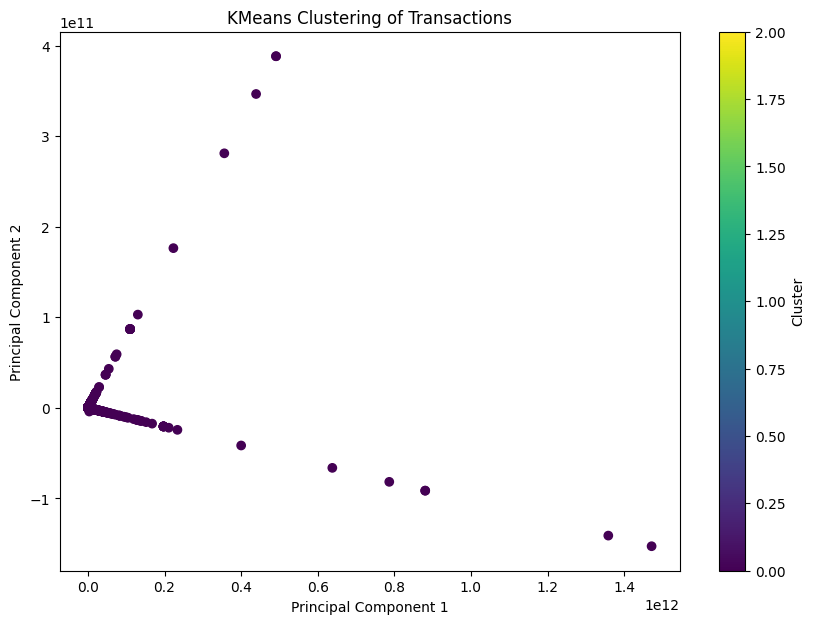

In [28]:
# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=reduced_df['Cluster'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering of Transactions')
plt.show()

We first take a look at the the PCA graph above, we can see that there are no definite clusters. Most of the points seems to be very close to each other or overlapping, which signifies very low variance. This means that the data points we have selected to cluster on are not very infromative because they do not add much noise to the data. However, let us inspect a few more features and add them to the feature list to culster the`From Bank` and `To Bank` on, and see if we can get some better clusters. We might also come back to this in the modeking step.

For now let's drop the `From Bank Cluster` that we created.

In [50]:
df_all = df_all.drop(columns= ['From Bank Cluster'])

### Payment Format

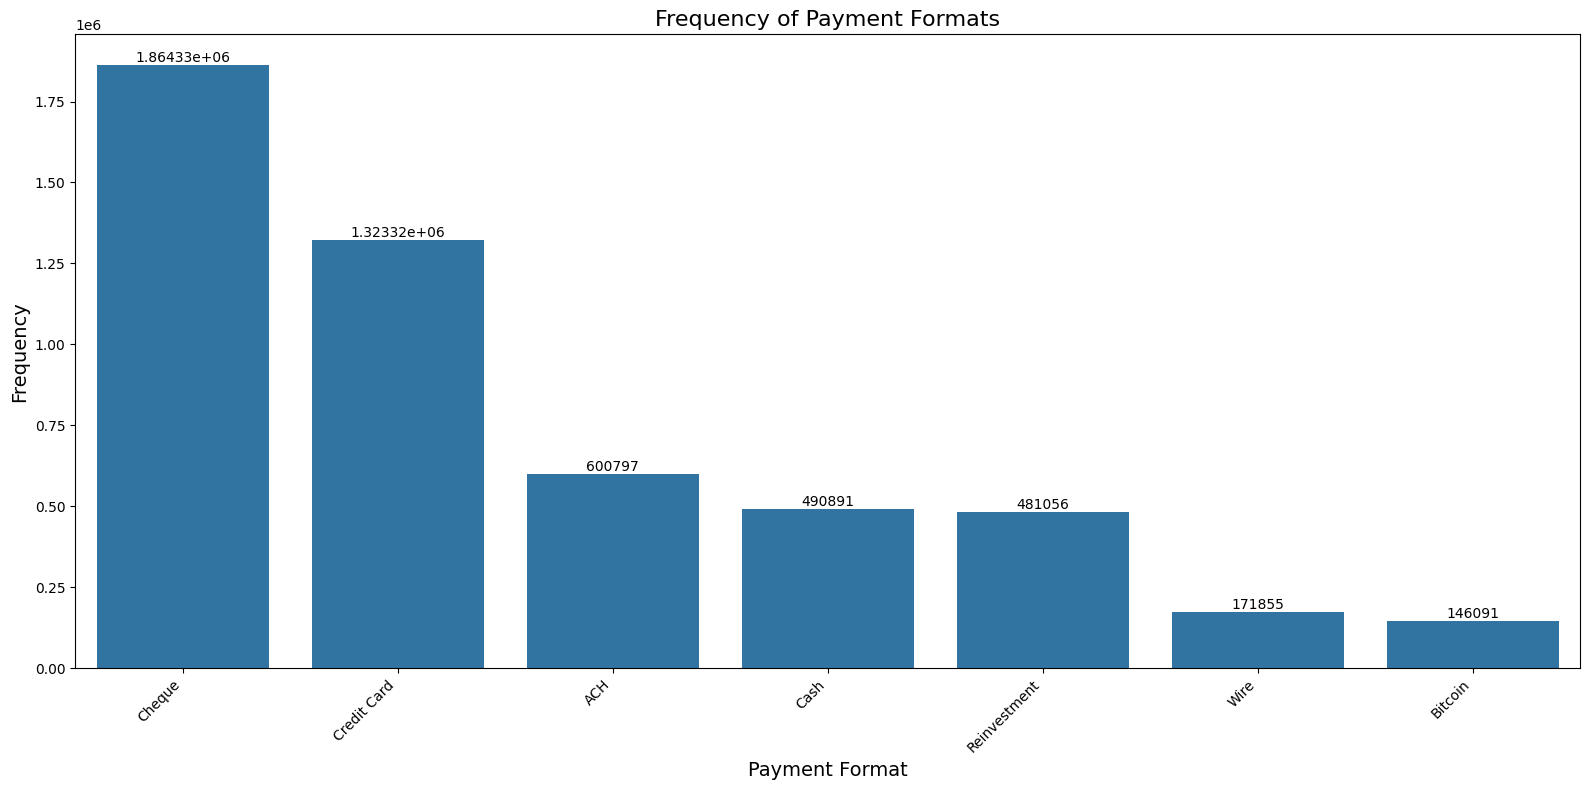

In [29]:

# Increase figure size
plt.figure(figsize=(16, 8))

# Plot bar graph using Seaborn
ax = sns.countplot(x='Payment Format', data=df_all,
                   order=df_all['Payment Format'].value_counts().index)

# Rotate x-axis labels and adjust their alignment
plt.xticks(rotation=45, ha='right')

# Increase font size for better readability
plt.title('Frequency of Payment Formats', fontsize=16)
plt.xlabel('Payment Format', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fontsize=10)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
# Counts
df_all['Payment Format'].value_counts()

,count
Payment Format,
Cheque,1864331
Credit Card,1323324
ACH,600797
Cash,490891
Reinvestment,481056
Wire,171855
Bitcoin,146091


In [31]:
# Percentages
df_all['Payment Format'].value_counts(normalize=True) * 100

,proportion
Payment Format,
Cheque,36.711389
Credit Card,26.058174
ACH,11.830567
Cash,9.666358
Reinvestment,9.472692
Wire,3.384075
Bitcoin,2.876744


Let us keep this feature as it is for now, because this could be useful to do some EDA on, and then we can one-got-encode it, when we get to the modeling part.

### Recieving Currency and Payment Currency :

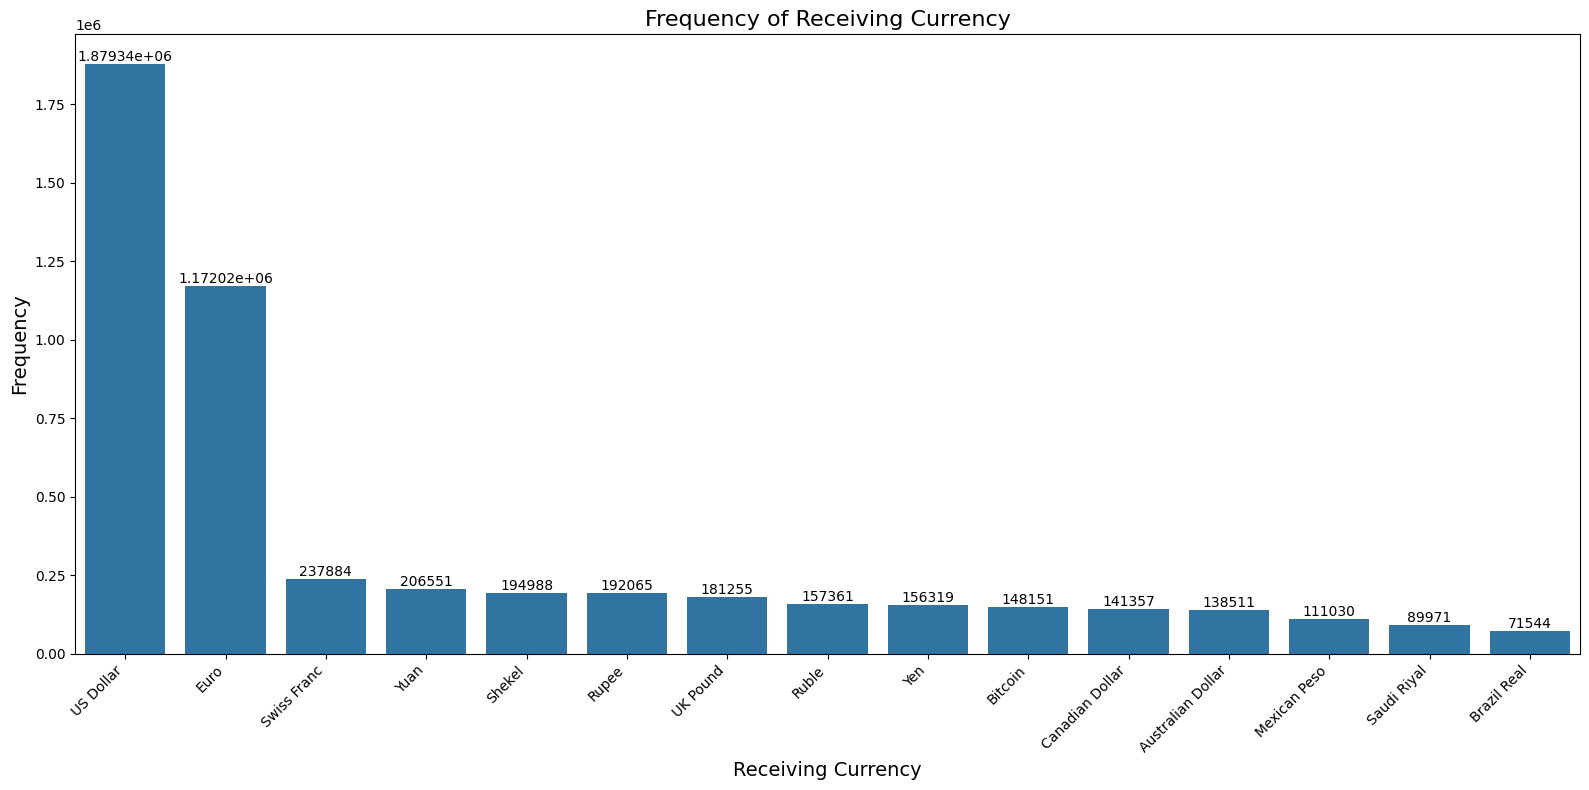

In [32]:
# Plot bar graph using Seaborn
# Increase figure size
plt.figure(figsize=(16, 8))

# Plot bar graph using Seaborn
ax = sns.countplot(x='Receiving Currency', data=df_all, order=df_all['Receiving Currency'].value_counts().index)

# Rotate x-axis labels and adjust their alignment
plt.xticks(rotation=45, ha='right')

# Increase font size for better readability
plt.title('Frequency of Receiving Currency', fontsize=16)
plt.xlabel('Receiving Currency', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fontsize=10)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [34]:
# Counts
df_all['Receiving Currency'].value_counts()

,count
Receiving Currency,
US Dollar,1879341
Euro,1172017
Swiss Franc,237884
Yuan,206551
Shekel,194988
Rupee,192065
UK Pound,181255
Ruble,157361
Yen,156319


In [35]:
# Percentages
df_all['Receiving Currency'].value_counts(normalize=True) * 100

,proportion
Receiving Currency,
US Dollar,37.006958
Euro,23.078720
Swiss Franc,4.684282
Yuan,4.067290
Shekel,3.839597
Rupee,3.782039
UK Pound,3.569175
Ruble,3.098667
Yen,3.078148


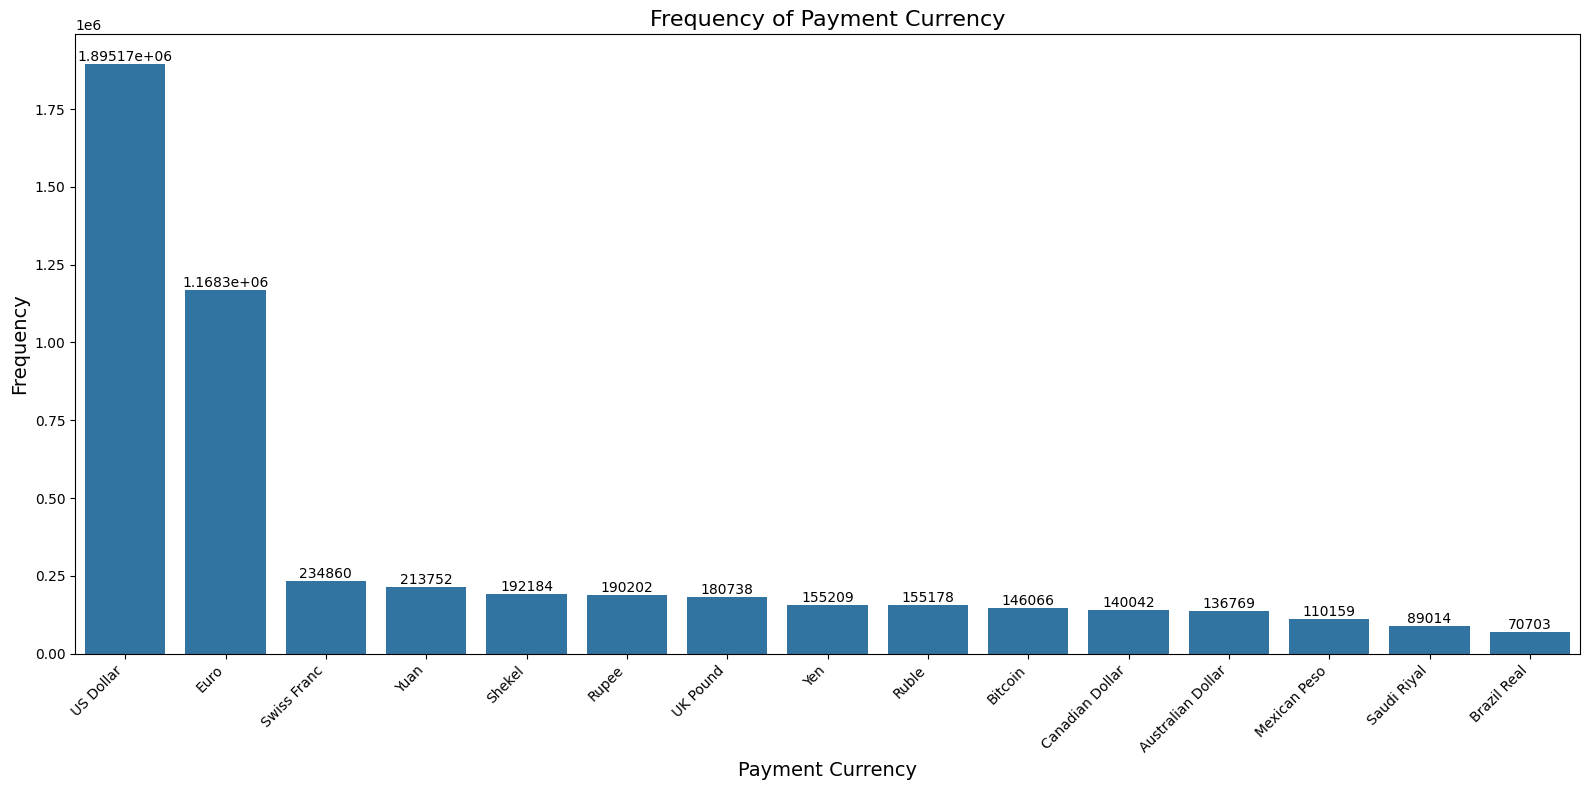

In [36]:
# Plot bar graph using Seaborn
# Increase figure size
plt.figure(figsize=(16, 8))

# Plot bar graph using Seaborn
ax = sns.countplot(x='Payment Currency', data=df_all, order=df_all['Payment Currency'].value_counts().index)

# Rotate x-axis labels and adjust their alignment
plt.xticks(rotation=45, ha='right')

# Increase font size for better readability
plt.title('Frequency of Payment Currency', fontsize=16)
plt.xlabel('Payment Currency', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fontsize=10)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [37]:
# Counts
df_all['Payment Currency'].value_counts()

,count
Payment Currency,
US Dollar,1895172
Euro,1168297
Swiss Franc,234860
Yuan,213752
Shekel,192184
Rupee,190202
UK Pound,180738
Yen,155209
Ruble,155178


Let us keep this the same too. We can do some EDA with it, and one-hot encode it when the time comes. However, what we can do is create a new feature called `Currency_Match`. Looking at the graphs above, it seems like the `Payment Currency` is not necessarily equal to the `Recieving Currency` and this might be another useful feature in determining whether a transaction is fraudulent or not.

In [38]:
df_all['Currency Match'] = (df_all['Payment Currency'] == df_all['Receiving Currency']).astype(int)
df_all['Currency Match'].value_counts()

,count
Currency Match,
1,5006175
0,72170


### Originating Account/ Receiving Account


The `Originating Account` and the `Receiving Account` are again two very high cardinality features. But there are two useful things that we can find out from this feature:
- `Account Match` : If the same account is both the origin and the recipient of a transaction, it might suggest an attempt to obscure the true nature of the transaction. This could be part of a strategy to launder money by making it appear as though funds are being circulated within the same account rather than being transferred.
- `Frequency of Transactions by Originating Account`:  Accounts with unusually high transaction frequencies may be involved in suspicious or fraudulent activities. For example, money laundering often involves structuring transactions to avoid detection, which might result in frequent transactions.
- `Frequency of Transactions by Receiving Account`: Same explaination as above



In [39]:
df_all['Originating_Account'].nunique()

420636

In [40]:
#Account Match
df_all['Account Match'] = (df_all['Originating_Account'] == df_all['Recieving_account']).astype(int)
df_all['Account Match'].value_counts()

,count
Account Match,
0,4487133
1,591212


In [41]:
# Count transactions for originating accounts
originating_counts = df_all['Originating_Account'].value_counts().reset_index()
originating_counts.columns = ['Originating_Account', 'Originating Transaction Count']

# Count transactions for receiving accounts
receiving_counts = df_all['Recieving_account'].value_counts().reset_index()
receiving_counts.columns = ['Recieving_account', 'Receiving Transaction Count']

In [42]:
originating_counts

,Originating_Account,Originating Transaction Count
0,100428660,1084
1,1004286A8,653
2,80F47A310,159
3,100428978,150
4,8018859B0,144
...,...,...
420631,80CB61400,1
420632,80081D9A0,1
420633,80CB62CF0,1
420634,80CB62ED0,1


In [43]:
receiving_counts

,Recieving_account,Receiving Transaction Count
0,100428660,168672
1,1004286A8,103018
2,100428978,20497
3,1004286F0,18663
4,100428780,17264
...,...,...
496990,80380C3B0,1
496991,803812430,1
496992,80CEEC270,1
496993,80380FA40,1


In [44]:
# Merge the counts back to the original DataFrame
df_all = df_all.merge(originating_counts, how='left', on='Originating_Account')
df_all = df_all.merge(receiving_counts, how='left', on='Recieving_account')

# Fill NaNs with 0 if needed
df_all['Originating Transaction Count'].fillna(0, inplace=True)
df_all['Receiving Transaction Count'].fillna(0, inplace=True)

In [45]:
df_all.head(20)

,Timestamp,From Bank,Recieving_account,To Bank,Originating_Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,Day,Hour,Minute,DayOfWeek,TimeDiff,From Bank Cluster,Currency Match,Account Match,Originating Transaction Count,Receiving Transaction Count
0,2022-09-01 00:06:00,320085,80E0DD780,70,100428660,0.06,US Dollar,0.06,US Dollar,Cash,...,1,0,6,3,0.0,0,1,0,1084,3
1,2022-09-01 00:22:00,31438,8032E38E0,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,...,1,0,22,3,960.0,0,1,0,1084,3
2,2022-09-01 05:38:00,310836,80DFCB240,70,100428660,0.03,US Dollar,0.03,US Dollar,Cash,...,1,5,38,3,18960.0,0,1,0,1084,3
3,2022-09-01 13:37:00,33138,80E2C5A90,70,100428660,0.02,US Dollar,0.02,US Dollar,Cash,...,1,13,37,3,28740.0,0,1,0,1084,3
4,2022-09-01 14:28:00,33407,80E157840,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,...,1,14,28,3,3060.0,0,1,0,1084,3
5,2022-09-01 22:11:00,33387,8081A4940,70,100428660,0.06,US Dollar,0.06,US Dollar,Cash,...,1,22,11,3,27780.0,0,1,0,1084,3
6,2022-09-02 00:02:00,317614,80E157F40,70,100428660,48.02,US Dollar,48.02,US Dollar,Cash,...,2,0,2,4,6660.0,0,1,0,1084,2
7,2022-09-02 00:03:00,31080,800F1A7B0,70,100428660,186.55,US Dollar,186.55,US Dollar,Cash,...,2,0,3,4,60.0,0,1,0,1084,2
8,2022-09-02 00:05:00,31277,8008F52E0,70,100428660,169.69,US Dollar,169.69,US Dollar,Cash,...,2,0,5,4,120.0,0,1,0,1084,2
9,2022-09-02 00:16:00,32206,8119E2280,70,100428660,73.75,US Dollar,73.75,US Dollar,Cash,...,2,0,16,4,660.0,0,1,0,1084,2


### Amount Paid/ Amount Received

In [48]:
df_all['Amount Paid'].describe()

,Amount Paid
count,5.078345e+06
mean,4.509273e+06
std,8.697728e+08
min,1.000000e-06
25%,1.844800e+02
50%,1.414540e+03
75%,1.229784e+04
max,1.046302e+12


In [49]:
df_all['Amount Received'].describe()

,Amount Received
count,5.078345e+06
mean,5.988726e+06
std,1.037183e+09
min,1.000000e-06
25%,1.833700e+02
50%,1.411010e+03
75%,1.234627e+04
max,1.046302e+12


Looking at the statistics above, it seems like the min and max for the Amount Paid and Amount Received respectiveley are anyhere between a couple of cents to a trillion dollars! Using these features as is in the model might not be that informational, so let us create the following new features out of it:
- `Amount Difference`: This feature helps identify discrepancies between the amounts sent and received. Large differences might indicate hidden fees, fraud, or laundering activities.
- `Amount Ratio`: The ratio can highlight abnormal transaction patterns. Ratios significantly different from 1 might indicate irregularities or attempts to disguise the true nature of the transactions.
- `Amount Paid Category`: Converting continuous data into categorical data can simplify the analysis and help in detecting patterns within specific ranges of transaction amounts.
- `Amount Received Category`: Same explanation as above
- `Z-score of Amount Paid`:Z-scores help in identifying outliers by measuring how many standard deviations a transaction amount is from the mean. Outliers can be indicative of fraudulent transactions or other irregular activitie
- `Z-score of Amount Received`: Same exmplanation as above.

(Here are the Z-score scales we could use)

- 1 ≤ Z ≤ 1: Normal Range
- 2 ≤ Z < -1 or 1 < Z ≤ 2: Potential Anomalies
- 3 ≤ Z < -2 or 2 < Z ≤ 3: Likely Anomalies
- Z < -3 or Z > 3: Strong Anomalies




In [56]:
df_all['Amount Difference'] = df_all['Amount Paid'] - df_all['Amount Received']
df_all['Amount Ratio'] = df_all['Amount Paid'] / df_all['Amount Received']

# Categorical features
bins = [0, 100, 1000, 10000, 100000, np.inf]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df_all['Amount Paid Category'] = pd.cut(df_all['Amount Paid'], bins=bins, labels=labels)
df_all['Amount Received Category'] = pd.cut(df_all['Amount Received'], bins=bins, labels=labels)

# Anomaly detection features
df_all['Z-Score Amount Paid'] = zscore(df_all['Amount Paid'])
df_all['Z-Score Amount Received'] = zscore(df_all['Amount Received'])

# Inspect the updated DataFrame
df_all.head(5)

,Timestamp,From Bank,Recieving_account,To Bank,Originating_Account,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,...,Currency Match,Account Match,Originating Transaction Count,Receiving Transaction Count,Amount Difference,Amount Ratio,Amount Paid Category,Amount Received Category,Z-Score Amount Paid,Z-Score Amount Received
0,2022-09-01 00:06:00,320085,80E0DD780,70,100428660,0.06,US Dollar,0.06,US Dollar,Cash,...,1,0,1084,3,0.0,1.0,Very Low,Very Low,-0.005184,-0.005774
1,2022-09-01 00:22:00,31438,8032E38E0,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,...,1,0,1084,3,0.0,1.0,Very Low,Very Low,-0.005184,-0.005774
2,2022-09-01 05:38:00,310836,80DFCB240,70,100428660,0.03,US Dollar,0.03,US Dollar,Cash,...,1,0,1084,3,0.0,1.0,Very Low,Very Low,-0.005184,-0.005774
3,2022-09-01 13:37:00,33138,80E2C5A90,70,100428660,0.02,US Dollar,0.02,US Dollar,Cash,...,1,0,1084,3,0.0,1.0,Very Low,Very Low,-0.005184,-0.005774
4,2022-09-01 14:28:00,33407,80E157840,70,100428660,0.01,US Dollar,0.01,US Dollar,Cash,...,1,0,1084,3,0.0,1.0,Very Low,Very Low,-0.005184,-0.005774


In [58]:
df_all['Amount Paid Category'].value_counts()

,count
Amount Paid Category,
Medium,1396270
Low,1376994
Very Low,934461
High,793993
Very High,576627


In [60]:
df_all['Amount Received Category'].value_counts()

,count
Amount Received Category,
Medium,1391886
Low,1375874
Very Low,938207
High,791072
Very High,581306


In [61]:
def classify_anomaly(z_score):
    if z_score > 3:
        return 'Strong Anomaly'
    elif z_score > 2:
        return 'Likely Anomaly'
    elif z_score > 1:
        return 'Potential Anomaly'
    else:
        return 'Normal'

# Apply anomaly classification
df_all['Anomaly Classification'] = df_all['Z-Score Amount Paid'].apply(classify_anomaly)

In [62]:
df_all['Anomaly Classification'].value_counts()

,count
Anomaly Classification,
Normal,5075616
Potential Anomaly,1289
Strong Anomaly,985
Likely Anomaly,455


In [ ]:
# Assuming `df` is your feature-engineered DataFrame
df_all.to_csv('feature_engineered_dataset.csv', index=False)